# Try out CNN on EEG data with labels

## Pre-processing
+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.

## Train CNN network
+ Define network architecture
+ Split data
+ Train model

### Use mcfly for some first model testing: https://github.com/NLeSC/mcfly

## Import packages & links

In [2]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
#%matplotlib inline

from mayavi import mlab

In [3]:
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_ePodium\\"
PATH_CODE = ROOT + "EEG_explorer\\"
PATH_DATA = ROOT + "Data\\"
PATH_OUTPUT = ROOT + "Data\\processed\\"
PATH_METADATA = ROOT + "Data\\metadata\\"
PATH_MODELS = ROOT + "trained_models\\"
file_labels = "metadata.xlsx"

import sys
sys.path.insert(0, PATH_CODE)

## Load pre-processed dataset
+ See notebook for preprocessing: Exploring_EEG_data_04_prepare_data_for_ML.ipynb

In [4]:
filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected.npy"
signal_collection = np.load(filename)

filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected_labels.npy"
label_collection = np.load(filename)

In [20]:
import csv
metadata = []
filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected_metadata.csv"
with open(filename, 'r') as readFile:
    reader = csv.reader(readFile, delimiter=',')
    for row in reader:
        if len(row) > 0:
            metadata.append(row)

readFile.close()
#writeFile.close()

In [23]:
metadata[:10]

[['1', '034_17_mc_mmn36_wk.cnt', '443'],
 ['2', '036_17_mc_mmn36_wk.cnt', '1384'],
 ['18', '175_17_jd_mmn_wk.cnt', '1858'],
 ['26', '305_17_jc_mmn36_wk.cnt', '2349'],
 ['27', '306_17_mc_mmn36_wk.cnt', '2813'],
 ['28', '307_17_jc_mmn36_wakker.cnt', '3447'],
 ['29', '308_17_jc_mmn36_wk.cnt', '3938'],
 ['30', '309_17_jc_mmn.cnt', '4425'],
 ['33', '314_17_mc_mmn36_wk.cnt', '4917'],
 ['38', '337_17_jc_mmn36_wk.cnt', '5389']]

## Split training data
The entire dataset is split into:
+ training data (here: about 70%) which is used to train a model.
+ validation data, used to monitor the model progress and avoid overfitting.
+ testing data, meant for final check on model performance.

#### Scale/normalize data

In [28]:
signal_collection.shape, int(metadata[0][2])

((39083, 30, 501), 443)

In [44]:
min_maxes = []
for ID in range(1,len(metadata)):
    min_maxes.append((signal_collection[int(metadata[ID-1][2]):int(metadata[ID][2]),:,:].min(), 
                     signal_collection[int(metadata[ID-1][2]):int(metadata[ID][2]),:,:].max()))

In [45]:
min_maxes

[(-0.0005257794210094777, 0.0005343373459647963),
 (-0.00043962778634980526, 0.0004696911098880744),
 (-0.0002695511826113613, 0.00027528431757866285),
 (-0.0004708642060900056, 0.0003292067192323345),
 (-0.0005355039365711072, 0.0005290691091432475),
 (-0.0003953305515463094, 0.00040033407195756146),
 (-0.0003983925464416893, 0.0005049639791991565),
 (-0.0003530323530318516, 0.00028270327444622587),
 (-0.00038487501840475175, 0.0004133488759047908),
 (-0.0006079226587074925, 0.0005020696253264277),
 (-0.0004898539715549783, 0.0004750931786297425),
 (-0.0003923630842347383, 0.00034165267684075273),
 (-0.00024006395903358355, 0.00028970959818429493),
 (-0.00021465818158849934, 0.00024308138181449582),
 (-0.00023346104083372328, 0.00022421514742338773),
 (-0.00034830567818646617, 0.00043354440512780436),
 (-0.0002693173098018898, 0.00037869777587576896),
 (-0.00043558261452503183, 0.00045431360339119646),
 (-0.00028899003373844757, 0.00023296708331957663),
 (-0.0006664719598646743, 0.001

In [4]:
data_max = signal_collection.max()
data_min = signal_collection.min()
data_mean = signal_collection.mean()

signal_collection = signal_collection - data_mean
signal_collection = signal_collection / data_max

#from sklearn.preprocessing import MinMaxScaler


In [5]:
signal_collection.min(), signal_collection.max()

(-0.8632916943089725, 0.9997598021039686)

In [6]:
label_collection[:10]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(signal_collection, label_collection, test_size=0.15, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

In [8]:
print('Train set size:', X_train.shape[0])
print('Validation set size:', X_val.shape[0])
print('Test set size:', X_test.shape[0])
print()
print("X_train mean, min, max: ", np.mean(X_train), np.min(X_train), np.max(X_train))

Train set size: 28237
Validation set size: 4983
Test set size: 5863

X_train mean, min, max:  0.00012076291398255782 -0.7504029467858274 0.9997598021039686


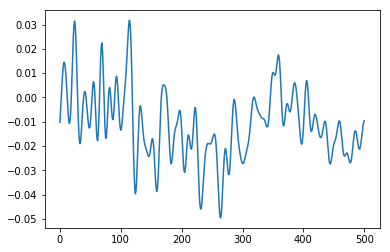

In [123]:
plt.plot(X_train[11,9,:])

## Switch to 1-hot encoding for labels
+ We have six categories or classes. Those are best represented by a so called 1-hot encoding. This means nothing else than simply a binary 0-or-1 for every class.. 

In [10]:
from sklearn.preprocessing import LabelBinarizer
label_transform = LabelBinarizer()

y_train_binary = label_transform.fit_transform(y_train.astype(int))
y_val_binary = label_transform.fit_transform(y_val.astype(int))
y_test_binary = label_transform.fit_transform(y_test.astype(int))

In [11]:
y_val_binary[:10,:]

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [12]:
# Show found labels:
label_transform.classes_

array([  3,   6,  13,  26,  66, 132])

Check distribution accross the 6 label categories:

In [13]:
labels = list(label_transform.classes_)
frequencies = y_train_binary.mean(axis=0)
frequencies_df = pd.DataFrame(frequencies, index=labels, columns=['frequency'])
frequencies_df

,frequency
3,0.313206
6,0.488437
13,0.038885
26,0.061515
66,0.038141
132,0.059815


### Note:
We have more data on group 2 than on group 1. And far more data for stimuli 3 than for stimuli 13 and 66 (not surprising). 

--> post on balancing datasets: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

### Needs some thinking on how to balance the data set !
e.g. by frequency dependend selection rule, or by defining a suitied special loss function....

In [14]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

In [15]:
class_weight

array([0.53213101, 0.34122438, 4.28612629, 2.70936481, 4.36969978,
       2.78636274])

In [16]:
class_weight = {0: 0.53213101,
               1: 0.34122438,
               2: 4.28612629,
               3: 2.70936481,
               4: 4.36969978,
               5: 2.78636274}

## Define model architecture

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


In [18]:
np.swapaxes(X_train,1,2)[:2000,:,:].shape

(2000, 501, 30)

In [19]:
# Model test 1

n_timesteps = 501
n_features = 30
n_outputs = 6

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 497, 64)           9664      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 248, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 246, 64)           12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 244, 64)           12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 122, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 120, 128)          24704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 60, 128)           0         
__________

In [21]:
epochs = 10
batch_size = 32
#verbose = 2

# fit network
model.fit(10*np.swapaxes(X_train,1,2), y_train_binary, 
          validation_data=(10*np.swapaxes(X_val,1,2), y_val_binary), epochs=epochs, batch_size=batch_size,
         class_weight = class_weight)


Instructions for updating:
Use tf.cast instead.
Train on 28237 samples, validate on 4983 samples
Epoch 1/10
28237/28237 [==============================] - 217s 8ms/step - loss: 3.4460 - acc: 0.1883 - val_loss: 1.7919 - val_acc: 0.0564
Epoch 2/10
28237/28237 [==============================] - 194s 7ms/step - loss: 1.7923 - acc: 0.1060 - val_loss: 1.7926 - val_acc: 0.0921
Epoch 3/10
28237/28237 [==============================] - 197s 7ms/step - loss: 1.7907 - acc: 0.1435 - val_loss: 1.7856 - val_acc: 0.1190
Epoch 4/10
28237/28237 [==============================] - 190s 7ms/step - loss: 1.7860 - acc: 0.1224 - val_loss: 1.7810 - val_acc: 0.1100
Epoch 5/10
28237/28237 [==============================] - 191s 7ms/step - loss: 1.7679 - acc: 0.2072 - val_loss: 1.7573 - val_acc: 0.0783
Epoch 6/10
28237/28237 [==============================] - 190s 7ms/step - loss: 1.7400 - acc: 0.1973 - val_loss: 1.7267 - val_acc: 0.1294
Epoch 7/10
28237/28237 [==============================] - 188s 7ms/step - l

## Not (yet) working...

In [22]:
# evaluate the model
#_, train_acc = model.evaluate(np.swapaxes(X_train,1,2), y_train_binary, verbose=0)
_, test_acc = model.evaluate(10*np.swapaxes(X_test,1,2), y_test_binary, verbose=0)

In [23]:
print(test_acc)

0.11717550743465921


In [24]:
np.swapaxes(X_test,1,2).shape

(5863, 501, 30)

In [39]:
Xtest = 10*np.swapaxes(X_test,1,2)

# check model predictions:
y_pred_proba = model.predict_proba(Xtest)
y_pred_classes = model.predict_classes(Xtest)

In [49]:
y_test_05 = y_test.copy()
y_test_05[y_test_05 == 132] = 5
y_test_05[y_test_05 == 66] = 4
y_test_05[y_test_05 == 26] = 3
y_test_05[y_test_05 == 13] = 2
y_test_05[y_test_05 == 6] = 1
y_test_05[y_test_05 == 3] = 0

print(y_test_05[:20].astype(int))
print(y_pred_classes[:20])

[0 0 0 1 0 1 4 1 1 0 0 1 0 1 1 1 0 0 1 1]
[2 2 0 5 5 5 5 5 3 5 4 3 2 5 5 4 3 2 5 5]


In [45]:
np.max(y_test_05)

5.0

In [41]:
# Calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test_05, y_pred_classes))

0.10131332082551595


In [46]:
# Confusion matrix:
M_confusion = metrics.confusion_matrix(y_test_05, y_pred_classes)
M_confusion

array([[ 185,  164,  305,  494,  346,  735],
       [  42,  147,   92,  995,  131, 1379],
       [  27,   21,   41,   49,   44,   63],
       [   0,    0,    0,    0,    0,    0],
       [  28,   19,   33,   55,   34,   68],
       [   4,   21,   10,  132,   12,  187]], dtype=int64)

# TO be continued...
+ Try with only 1 binary label --> Risk group vs Not-risk group
+ Test LSTM
+ Work with higher compression --> more pooling in the beginning ?

# 2. Reduce categories:
One problem might arise from that fact that we don't know the stimuli!  
Very likely either "13 or "66" means that same as "3" and hence CANNOT be distinguishes by the model...  
Here I would like to explore a bit what happens if we only look at 2 categories instead of 6.

## Switch to 1-hot encoding for labels
+ We have six categories or classes. Those are best represented by a so called 1-hot encoding. This means nothing else than simply a binary 0-or-1 for every class.. 

In [83]:
y_test[:100]

array([  3.,   3.,   3.,   6.,  26.,   6.,  66.,   6.,   6.,   3.,   3.,
         6.,   3.,   6.,   6.,   6.,  26.,   3.,   6.,   6.,   6.,   6.,
         6.,   3.,   3.,  66.,   3.,   6.,  66.,   3.,   6.,  66.,  13.,
         6.,   3.,   6.,   6., 132.,   3.,   6.,   3.,  26.,   3., 132.,
         3.,   3.,  66.,   3.,   3.,   3.,   6.,   6.,   6.,   6.,   6.,
         3.,  66.,   3.,   3.,   6.,   6.,   6.,   3.,   3.,   3.,   3.,
         6.,   3.,   6.,   6.,   3.,   3.,  66.,   3.,   6.,   6., 132.,
        66.,   6.,   6.,   3.,   3.,   3.,   6.,  66., 132.,   6.,   3.,
         3.,   6.,   3.,   6.,   6.,   3.,   6.,   6.,  66.,  13.,   3.,
         3.])

In [50]:
# only pick two categories! -> here: 3 and 6
select = np.where((y_train == 3 ) | (y_train == 6 )) 
y_train2 = y_train[select]
X_train2 = X_train[select]

select = np.where((y_val == 3 ) | (y_val == 6 )) 
y_val2 = y_val[select]
X_val2 = X_val[select]

select = np.where((y_test == 3 ) | (y_test == 6 )) 
y_test2 = y_test[select]
X_test2 = X_test[select]

In [81]:
select[0][:10]

array([ 0,  1,  2,  3,  5,  7,  8,  9, 10, 11], dtype=int64)

In [101]:
X_train.shape, X_train2.shape, y_train.shape, y_train2.shape

((28237, 30, 501), (22636, 30, 501), (28237,), (22636,))

In [52]:
from sklearn.preprocessing import LabelBinarizer
label_transform = LabelBinarizer()

y_train2_binary = label_transform.fit_transform(y_train2.astype(int))
y_val2_binary = label_transform.fit_transform(y_val2.astype(int))
y_test2_binary = label_transform.fit_transform(y_test2.astype(int))

In [105]:
print(y_val2_binary[:40,0])

[0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0
 1 1 1]


In [54]:
# Show found labels:
label_transform.classes_

array([3, 6])

Check distribution accross the 2 selected label categories:

In [56]:
labels = list(label_transform.classes_)
frequencies = y_train2_binary.mean(axis=0)

frequencies

array([0.60929493])

### Note:
We have more data on group 2 than on group 1. And far more data for stimuli 3 than for stimuli 13 and 66 (not surprising). 

--> post on balancing datasets: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

### Needs some thinking on how to balance the data set !
e.g. by frequency dependend selection rule, or by defining a suitied special loss function....

In [57]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train2)
                                               ,y_train2)

In [58]:
class_weight

array([1.27973768, 0.82062065])

In [59]:
class_weight = {0: 1.27973768,
               1: 0.82062065}

## Define model architecture

In [118]:
# Model test 2
from keras.layers import BatchNormalization
from keras import optimizers

n_timesteps = 501
n_features = 30
n_outputs = 1

optimizer = optimizers.SGD(lr=0.0001, momentum=0.1, decay=0.1, nesterov=False)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(BatchNormalization())
#model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))
#model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 493, 64)           17344     
_________________________________________________________________
batch_normalization_3 (Batch (None, 493, 64)           256       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 246, 64)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 240, 64)           28736     
_________________________________________________________________
batch_normalization_4 (Batch (None, 240, 64)           256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 240, 64)           0         
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 120, 64)           0         
__________

In [110]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
output_file = 'CNN_EEG_classifier'

checkpointer = ModelCheckpoint(filepath = PATH_MODELS + output_file + ".hdf5", monitor='val_acc', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

In [111]:
np.max(X_train2[0])

0.0812634354474251

In [119]:
epochs = 10
batch_size = 32

# fit network
model.fit(1*np.swapaxes(X_train2,1,2), y_train2_binary, 
          validation_data = (1*np.swapaxes(X_val2,1,2), y_val2_binary), 
          epochs = epochs, 
          batch_size = batch_size,
          #class_weight = class_weight,
          callbacks = [checkpointer, earlystopper])

Train on 22636 samples, validate on 3961 samples
Epoch 1/10
22636/22636 [==============================] - 212s 9ms/step - loss: 6.2288 - acc: 0.6093 - val_loss: 6.2989 - val_acc: 0.6049

Epoch 00001: val_acc did not improve from 0.60490
Epoch 2/10
22636/22636 [==============================] - 192s 8ms/step - loss: 6.2288 - acc: 0.6093 - val_loss: 6.2989 - val_acc: 0.6049

Epoch 00002: val_acc did not improve from 0.60490
Epoch 3/10
16736/22636 [=====================>........] - ETA: 45s - loss: 6.2737 - acc: 0.6065

KeyboardInterrupt: 

In [71]:
# evaluate the model
#_, train_acc = model.evaluate(np.swapaxes(X_train,1,2), y_train_binary, verbose=0)
_, test_acc = model.evaluate(10*np.swapaxes(X_test2,1,2), y_test2_binary, verbose=0)

In [73]:
print(test_acc)
print(y_test2_binary.mean())

0.5960633290543432
0.5960633290543432


In [74]:
Xtest = 10*np.swapaxes(X_test2,1,2)[:200,:,:]

In [75]:
ytest = model.predict_proba(Xtest)
ytest

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],